In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D

import time
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from tqdm import tqdm

Kmeans assignes cluster labels based on the distance from the data point to the cluster. In the $k=2$ case, the boundary where data points could be assigned to either cluster lies on a hyperplane halfway between the cluster centers. In the $d=1$ example, letting our kmeans classifier be a function g such that

Our data is composed of 2 sets of n $(x,y)$ pairs drawn from distributions $F_0, F_1$, where
$$F_0 \sim N(0,0.5),\ F_1 \sim N(1,0.5)$$

$$L(g(x)) = P(g(x|y=0)=1)+P(g(x+y=1)=0)$$

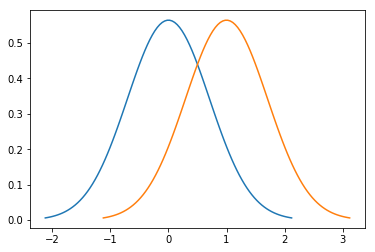

In [45]:
mu = 0
variance = 0.5
sigma = np.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))
mu = 1
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()

Since I have controlled the distance to be exactly 1, we can evaluate the error as the sum of the 2 tail integrals of the clusters on the opposite side of the decision boundary,
$$\int_{0.5}^\infty \frac{1}{0.5\sqrt{2\pi}}e^{\frac{x^2}{2(0.5)^2}}\,dx + \int_{-\infty}^{0.5} \frac{1}{0.5\sqrt{2\pi}}e^{\frac{(x-1)^2}{2(0.5)^2}}\,dx$$
Since the areas are symmetric, we can just find one of the integrals and multiply it by 2
$\begin{align*}
    P(g(X)=1|Y=0) &= P(N(1,0.5)<0.5)\\
    &= P(N(0,0.5)<-0.5)\\
    &= P(\frac{1}{4}N(0,1)<-0.5)\\
    &= P(N(0,1)<-2)\\
    &= 0.0228
\end{align*}$

So our final Bayes optimal error for this one-dimensional case is 0.0456, 4.5%

Let $X|Y \sim Normal(Y,\Sigma)$, $Y \in \{0,1\}$

Where $\Sigma = \begin{bmatrix}\sigma^2 & 0 & \dots\\0 & \sigma^2 & 0\\\dots&0&\sigma^2\end{bmatrix}, \sigma^2 = 0.5$

The cluster sizes are balanced, so $\pi_1 = \pi_2 = 0.5$

$$MLE_{err} = \int_{\mathbb{R}^d} min\Big(\pi_1 f_1(\mu_1, \Sigma_1), \pi_2 f_2(\mu_2, \Sigma_2)\Big)\,dx$$
$$lik(f_1,f_2)(x) = log\Big(\frac{f_2(\mu_2, \Sigma_2)(x)}{f_1(\mu_1, \Sigma_1)(x)}\Big)$$

We tune the means of each distribution so they have constant euclidean distance separation of 1

In [24]:
def gen_d_dim_data(d, n=100):
    data = []
    mean_0 = [0]*d
    mean_1 = [np.sqrt(1/d)]*d
    cov_var = [0.5]*d
    cov = np.diag(cov_var)
    data_0 = np.random.multivariate_normal(mean_0, cov, n)
    data_1 = np.random.multivariate_normal(mean_1, cov, n)
    return data_0, data_1

In [56]:
def cluster(data, init0='random', clf='kmeans'):
    if clf=='kmeans':
        classifier = KMeans(n_clusters=2, init=init0, max_iter=1)
    elif clf=='gmm':
        classifier = GaussianMixture(n_components=2, init_params=init0, covariance_type='diag')
    else:
        print('specify classifier')
    t0 = time.time()
    classifier.fit(data)
    t1 = time.time()
    dur = t1-t0
    klabels = classifier.predict(data)
    if np.sum(klabels[:50]) > 25:
        klabels = 1-klabels
    klabels_0 = data[klabels==0]
    klabels_1 = data[klabels==1]
    half = len(data)//2
    dlabels = np.concatenate(([0]*half,[1]*(len(data)-half)),axis=0)
    err = np.sum(((dlabels!=klabels)))/len(data)
    return klabels, klabels_0, klabels_1, err, dur

In [48]:
def plot_clusters(d, data_0, data_1, klabels_0, klabels_1, clf='kmeans'):
    if d==1:
        plt.figure(figsize=(12,8))
        plt.suptitle(clf+' behavior on 1 dimension', fontsize=20)
        plt.subplot(121)
        plt.plot([0]*len(data_0) , data_0, 'r.', alpha=0.5)
        plt.plot([0]*len(data_1) , data_1, 'b.', alpha=0.5)
        plt.subplot(122)
        plt.plot([0]*len(klabels_0), klabels_0, 'r.', alpha=0.5)
        plt.plot([0]*len(klabels_1), klabels_1, 'b.', alpha=0.5)
        plt.show()
    elif d==2:
        plt.figure(figsize=(12,8))
        plt.suptitle(clf+' behavior on 2 dimensions', fontsize=20)
        plt.subplot(121)
        plt.plot(data_0[:,0], data_0[:,1], 'r.', alpha=0.5)
        plt.plot(data_1[:,0], data_1[:,1], 'b.', alpha=0.5)
        plt.subplot(122)
        plt.plot(klabels_0[:,0], klabels_0[:,1], 'r.', alpha=0.5)
        plt.plot(klabels_1[:,0], klabels_1[:,1], 'b.', alpha=0.5)
        plt.show()
    elif d==3:
        fig = plt.figure(figsize=(12,8))
        fig.suptitle(clf+' behavior on 3 dimensions', fontsize=20)
        ax = fig.add_subplot(121, projection='3d')
        ax.scatter(data_0[:,0], data_0[:,1], data_0[:,2], 'r.', alpha=0.5)
        ax.scatter(data_1[:,0], data_1[:,1], data_1[:,2], 'b.', alpha=0.5)
        ax = fig.add_subplot(122, projection='3d')
        ax.scatter(klabels_0[:,0], klabels_0[:,1], klabels_0[:,2], 'r.', alpha=0.5)
        ax.scatter(klabels_1[:,0], klabels_1[:,1], klabels_1[:,2], 'b.', alpha=0.5)
        plt.show()

In [49]:
def look_at_it(d, n=100, init0='random', clf='kmeans', log_err=False):
    data_0, data_1 = gen_d_dim_data(d)
    data = np.concatenate((data_0,data_1), axis=0)
    klabels, klabels_0, klabels_1, err, dur = cluster(data, init0, clf)
    print(clf+',', init0, 'initialization in',d,'dimensions')
    plot_clusters(d, data_0, data_1, klabels_0, klabels_1)
    if log_err:
        print('error:', err)

kmeans, random initialization in 3 dimensions


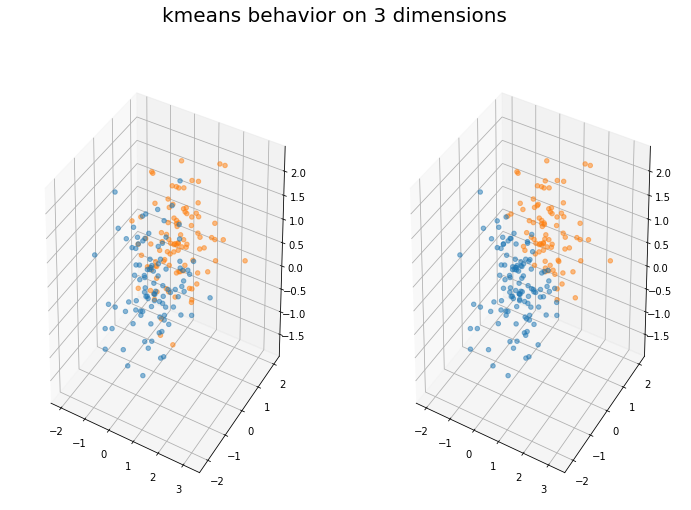

error: 0.245


In [50]:
look_at_it(3, n=100, init0='random', clf='kmeans', log_err=True)

In [51]:
def monte(d, n=100, n_iter=100, init0='random', clf='kmeans'):
    times = []
    errors = []
    for _ in range(n_iter):
        data_0, data_1 = gen_d_dim_data(d, n)
        data = np.concatenate((data_0,data_1), axis=0)
        dlabels = np.concatenate(([0]*n,[1]*n),axis=0)
        klabels, klabels_0, klabels_1, kerr, dur = cluster(data, init0, clf)
        times.append(dur)
        errors.append(np.sum(((dlabels!=klabels)))/len(data))
    time0 = (np.mean(times), np.std(times))
    err = (np.mean(errors), np.std(errors))
    return time0, err

In [33]:
def get_monte_data(x=[1,10,100,1000], d=1, n=100, n_iter=100, init0='random', clf='kmeans'):
    dtimes = []
    dtimes_std = []
    derrors = []
    derrors_std = []
    ntimes = []
    ntimes_std = []
    nerrors = []
    nerrors_std = []
    for val in tqdm(x):
        time0, err = monte(d, val, n_iter, init0, clf)
        ntimes.append(time0[0])
        ntimes_std.append(time0[1])
        nerrors.append(err[0])
        nerrors_std.append(err[1])
    for val in tqdm(x):
        time0, err = monte(val, n, n_iter, init0, clf)
        dtimes.append(time0[0])
        dtimes_std.append(time0[1])
        derrors.append(err[0])
        derrors_std.append(err[1])
    n_vec = (ntimes, ntimes_std, nerrors, nerrors_std)
    d_vec = (dtimes, dtimes_std, derrors, derrors_std)
    return n_vec, d_vec

In [34]:
x_n = [1,10,100,1000]

In [38]:
n_vec_random, d_vec_random = get_monte_data(\
                    x=[1,10,100,500], d=1, n=100, n_iter=100,\
                    init0='random', clf='kmeans') #time, time std, error, error std
n_vec_plus, d_vec_plus = get_monte_data(\
                    x=[1,10,100,500], d=1, n=100, n_iter=100,\
                    init0='k-means++', clf='kmeans') #time, time std, error, error std

100%|██████████| 4/4 [00:13<00:00,  3.38s/it]


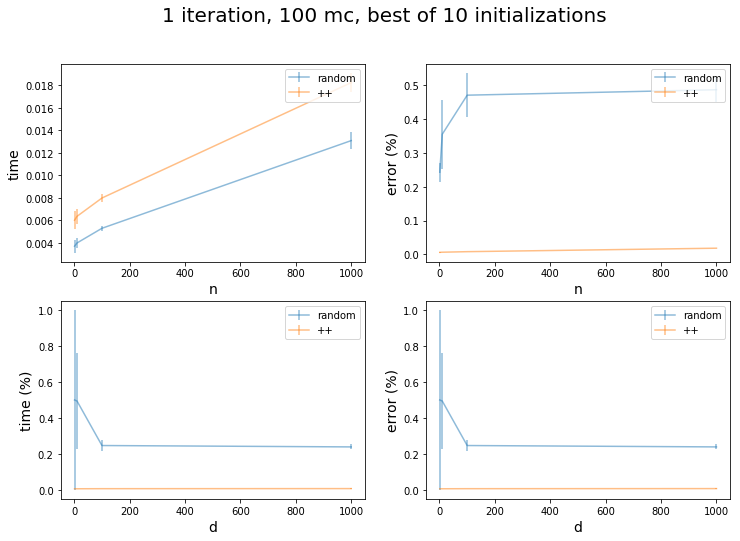

10 centroid seeds


In [42]:
plt.figure(figsize=(12,8))
plt.suptitle('1 iteration, 100 mc, best of 10 initializations', fontsize='20')
plt.subplot(221)
plt.errorbar(x_n, d_vec_random[0], yerr=d_vec_random[1], alpha=0.5, label='random')
plt.errorbar(x_n, d_vec_plus[0], yerr=d_vec_plus[1], alpha=0.5, label='++')
plt.xlabel('n', fontsize='14')
plt.ylabel('time', fontsize='14')
plt.legend(loc = 'upper right')
plt.subplot(222)
plt.errorbar(x_n, d_vec_random[2], yerr=d_vec_random[3], alpha=0.5, label='random')
plt.errorbar(x_n, d_vec_plus[0], yerr=d_vec_plus[1], alpha=0.5, label='++')
plt.xlabel('n', fontsize='14')
plt.ylabel('error (%)', fontsize='14')
plt.legend(loc = 'upper right')
plt.subplot(223)
plt.errorbar(x_n, n_vec_random[2], yerr=n_vec_random[3], alpha=0.5, label='random')
plt.errorbar(x_n, n_vec_plus[0], yerr=n_vec_plus[1], alpha=0.5, label='++')
plt.xlabel('d', fontsize='14')
plt.ylabel('time (%)', fontsize='14')
plt.legend(loc = 'upper right')
plt.subplot(224)
plt.errorbar(x_n, n_vec_random[2], yerr=n_vec_random[3], alpha=0.5, label='random')
plt.errorbar(x_n, n_vec_plus[0], yerr=n_vec_plus[1], alpha=0.5, label='++')
plt.xlabel('d', fontsize='14')
plt.ylabel('error (%)', fontsize='14')
plt.legend(loc = 'upper right')
plt.show()
print('10 centroid seeds')

In [57]:
n_vec_random, d_vec_random = get_monte_data(\
                    x=[1,10,100,500], d=1, n=100, n_iter=100,\
                    init0='random', clf='gmm') #time, time std, error, error std
n_vec_plus, d_vec_plus = get_monte_data(\
                    x=[1,10,100,500], d=1, n=100, n_iter=100,\
                    init0='kmeans', clf='gmm') #time, time std, error, error std

100%|██████████| 4/4 [00:12<00:00,  3.24s/it]


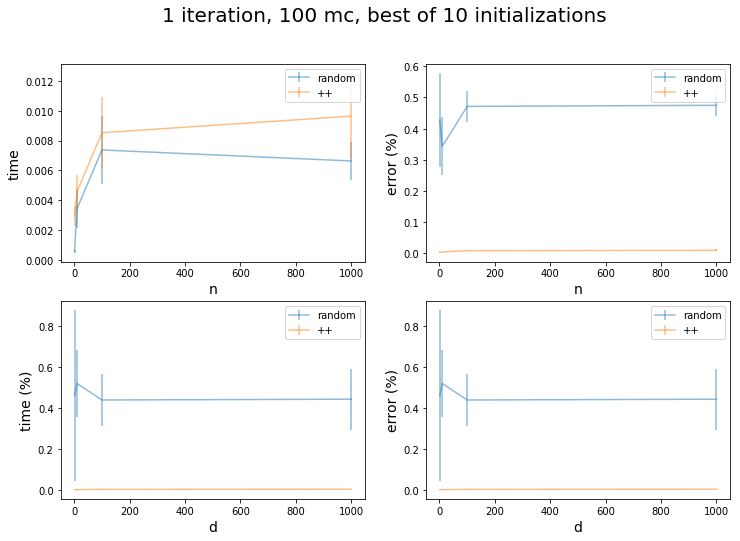

10 centroid seeds


In [58]:
plt.figure(figsize=(12,8))
plt.suptitle('1 iteration, 100 mc, best of 10 initializations', fontsize='20')
plt.subplot(221)
plt.errorbar(x_n, d_vec_random[0], yerr=d_vec_random[1], alpha=0.5, label='random')
plt.errorbar(x_n, d_vec_plus[0], yerr=d_vec_plus[1], alpha=0.5, label='++')
plt.xlabel('n', fontsize='14')
plt.ylabel('time', fontsize='14')
plt.legend(loc = 'upper right')
plt.subplot(222)
plt.errorbar(x_n, d_vec_random[2], yerr=d_vec_random[3], alpha=0.5, label='random')
plt.errorbar(x_n, d_vec_plus[0], yerr=d_vec_plus[1], alpha=0.5, label='++')
plt.xlabel('n', fontsize='14')
plt.ylabel('error (%)', fontsize='14')
plt.legend(loc = 'upper right')
plt.subplot(223)
plt.errorbar(x_n, n_vec_random[2], yerr=n_vec_random[3], alpha=0.5, label='random')
plt.errorbar(x_n, n_vec_plus[0], yerr=n_vec_plus[1], alpha=0.5, label='++')
plt.xlabel('d', fontsize='14')
plt.ylabel('time (%)', fontsize='14')
plt.legend(loc = 'upper right')
plt.subplot(224)
plt.errorbar(x_n, n_vec_random[2], yerr=n_vec_random[3], alpha=0.5, label='random')
plt.errorbar(x_n, n_vec_plus[0], yerr=n_vec_plus[1], alpha=0.5, label='++')
plt.xlabel('d', fontsize='14')
plt.ylabel('error (%)', fontsize='14')
plt.legend(loc = 'upper right')
plt.show()
print('10 centroid seeds')